In [2]:
import torch

# pip install jupyterthemes
##Turn on the dark mode 
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import time
from tqdm import tqdm
import os
import pickle
import RNN_multitask_utils as rn


GPU available on Mac: mps


### Define network

In [2]:
# network parameters
step_n=2000
neuron_n = 2**14  # number of nodes
g_scale = 1.0     # std of recurrent couplings (fix to 1)
J_bias = 0.5      # mean of recurrent couplings
theta = 1         # threshold
mu=0.52           # mean of external input at baseline
c = 5             # transfer function gain (equivalent to std of recurrent couplings)
replica_n = 1     # number of replicas
time_slice = 1.0  #size of discretized time step
act_type = 2        #activation function type, act_type = 1 (tanh), 2(sigmoid), 3(ReLU)
sigma_ind = 0.195   # baseline variance
initial_var=0.1  # variance of initial condition
N=neuron_n

parameters1={"neuron_n":neuron_n,"replica_n":replica_n,"step_n":step_n,"time_slice":time_slice,"act_type":act_type} 
print(parameters1)

{'neuron_n': 16384, 'replica_n': 1, 'step_n': 2000, 'time_slice': 1.0, 'act_type': 2}


### Explore phase transitions

Within a single bistable phase, explore which stimuli drive network to either basin using neural hysteresis.

Two options: FixedPoint/Chaos bistable phase, or DoubleFixedPoint bistable phase.

In [5]:
# pick which phase transition to explore:

# phaseTrans='FPChaos'
phaseTrans='DoubleFP'


{'g_scale': 1.0, 'J_bias': 0.5, 'mu': 0.52, 'theta': 1, 'c': 5, 'sigma_ind': 0.195, 'initial_var': 0.1, 'stim_data': {'stim': array([0.5 , 0.54, 0.5 , 0.54]), 'stim_times': [300, 800, 1300, 1800], 'stim_labels': array([0., 1., 0., 1.]), 'stim_interval': 500, 'stim_dur': 50, 'stim_offset': 300, 'jitter': False}, 'J': [], 'quench_noise1': [], 'task_rule': {'mu': [0.48, 0.52], 'sigma': [0.18, 0.18], 'time_onset': [0, 100], 'time_offset': [99, 2000]}}
Start
running # tasks=2
generate quenched noise


  7%|▋         | 135/2000 [00:00<00:08, 225.32it/s]

end of task 0


 19%|█▊        | 374/2000 [00:02<00:11, 139.53it/s]

end of stim0


 43%|████▎     | 867/2000 [00:05<00:07, 142.92it/s]

end of stim1


 69%|██████▉   | 1376/2000 [00:09<00:04, 146.03it/s]

end of stim2


 94%|█████████▎| 1870/2000 [00:13<00:01, 115.51it/s]

end of stim3


100%|██████████| 2000/2000 [00:14<00:00, 138.84it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time on GPU (torch): 14.483776092529297
hozon


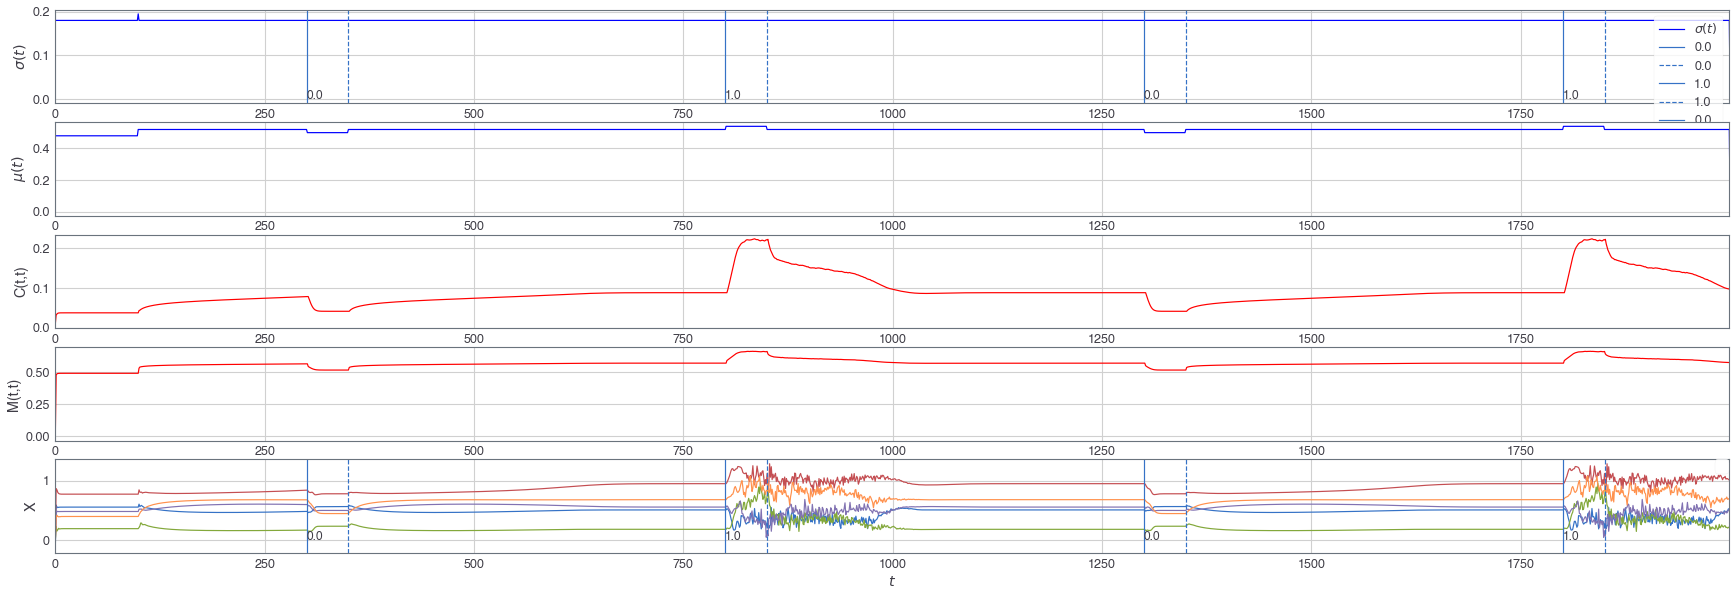

In [6]:
"""
N body simulation
Transition between two meta equilibrium state
"""


if phaseTrans=='FPChaos':
    # schedule: apply task rule, then stimulate a few times, then change task rule, then stimulate again, then change back again, stimulate 
    # task rule is sustained value of mu,sigma 
    # new variables: 
    mu0=0.48; sigma0=0.18; # deep into FP, go there and then get back to get FP branch of FP/chaos.
    mu1=0.52; sigma1=0.18; # FP/chaos
    # design stimuli
    # FP stimuli: mu and sigma from fixed point area
    # design stimuli to get the total mu right, and then remove the current mu_set value so that stimuli are just adding to that.
    stim_class=['FP','Chaos']
    mu_FP=0.5; # stimulus 1 drives network transiently into the FP region
    mu_Chaos=0.54; # stimulus 2 drives network transiently into the Chaos region
    mu_stim=[mu_FP,mu_Chaos] #; sigma_stim=[sigma_FP,sigma_Chaos]
elif phaseTrans=='DoubleFP':
    # schedule: apply task rule, then stimulate a few times, then change task rule, then stimulate again, then change back again, stimulate 
    # task rule is sustained value of mu,sigma 
    # new variables: 
    mu0=0.53; sigma0=0.188; # deep into FP, go there and then get back to get FP branch of FP/chaos.
    mu1=0.5125; sigma1=0.1883;  # double FP
    # design stimuli
    # FP stimuli: mu and sigma from fixed point area
    # design stimuli to get the total mu right, and then remove the current mu_set value so that stimuli are just adding to that.
    stim_class=['FP1','FP2']
    mu_FP1=0.507; #  stimulus 1 drives network transiently into the FP 1 region
    mu_FP2=0.517; #  stimulus 2 drives network transiently into the FP 2 region
    mu_stim=[mu_FP1,mu_FP2] #; sigma_stim=[sigma_FP,sigma_Chaos]
    
t0=0; t1=100 
mu_set=[mu0,mu1]; sigma_set=[sigma0,sigma1]
time_onset=[t0,t1]; time_offset=[t1-1,step_n]; 
task_rule={'mu':mu_set,'sigma':sigma_set,'time_onset':time_onset,'time_offset':time_offset}
nstim=2 # stim per class

stim=np.zeros(nstim*2); stim_labels=np.zeros(nstim*len(stim_class))
cnt=0
for i in range(nstim):
    for iclass in range(len(stim_class)):
        stim_labels[cnt]=iclass
        stim[cnt]=mu_stim[iclass]
        cnt=cnt+1

stim_interval=500 # interval between 2 cons stimulations
stim_dur=50 # duration of a stimulation
stim_offset=t1+200 # offset of first stim from beginning of sim
stim_times=[stim_offset+i*stim_interval for i in range(nstim*len(stim_class))]
stim_data={"stim":stim,"stim_times":stim_times,'stim_labels':stim_labels,"stim_interval":stim_interval,"stim_dur":stim_dur,"stim_offset":stim_offset,'jitter':False}
    
J =[]#

parameters5={"g_scale":g_scale,"J_bias":J_bias,"mu":mu,"theta":theta,"c":c,"sigma_ind":sigma_ind,"initial_var":initial_var,"stim_data":stim_data,"J":J,'quench_noise1':[],"task_rule":task_rule} 
print(parameters5)
   
    
start = time.time()
print("Start")
    
RRNNN = rn.RecurrentRandomNeuralNetworkNbody(**parameters1)

output = RRNNN.evolve_rrnn_switch(**parameters5)

stop = time.time()
print("Time on GPU (torch): "+str(stop-start))
pdffigname = "switch_g"+str(g_scale)+"_Jbias"+str(J_bias)+"_c"+str(c)+"_theta"+str(theta)+"_neuron_n"+str(neuron_n)+".pdf"
rn.plot_time_course_stim(step_n,output,stim_data,time_slice,pdffigname)

## Save network weights

If the simulations above for the bistable phase DoubleFP exhibits two nice fixed points, then save the weight matrix with the cell below. These weights are going to be uploaded for the task.

In [8]:
# save simulation

file_data=os.path.join('DATA',"sim_ExploreBistablePhases"+phaseTrans+".pickle")
with open(file_data, 'wb') as fp:
    pickle.dump(output, fp, protocol=pickle.HIGHEST_PROTOCOL)# with open(file_data, 'r') as f:


Load weights from a good DoubleFP simulation above.

Run long session with multiple switches between rules and trials

running # tasks=8
using J from input
use quenched noise from input


 12%|█▏        | 507/4201 [00:09<01:14, 49.86it/s]

end of stim0


 17%|█▋        | 705/4201 [00:13<01:11, 48.96it/s]

end of task 0


 24%|██▍       | 1005/4201 [00:20<01:08, 46.76it/s]

end of stim1


 29%|██▊       | 1205/4201 [00:24<01:04, 46.56it/s]

end of task 1


 36%|███▌      | 1505/4201 [00:30<00:55, 48.18it/s]

end of stim2


 41%|████      | 1705/4201 [00:35<00:55, 44.91it/s]

end of task 2


 48%|████▊     | 2006/4201 [00:42<01:11, 30.66it/s]

end of stim3


 53%|█████▎    | 2206/4201 [00:49<01:05, 30.25it/s]

end of task 3


 60%|█████▉    | 2503/4201 [00:59<00:59, 28.60it/s]

end of stim4


 64%|██████▍   | 2704/4201 [01:06<00:53, 28.00it/s]

end of task 4


 72%|███████▏  | 3004/4201 [01:17<00:43, 27.59it/s]

end of stim5


 76%|███████▋  | 3205/4201 [01:24<00:37, 26.64it/s]

end of task 5


 83%|████████▎ | 3505/4201 [01:36<00:26, 26.43it/s]

end of stim6


 88%|████████▊ | 3703/4201 [01:43<00:19, 25.84it/s]

end of task 6


 95%|█████████▌| 4003/4201 [01:55<00:07, 25.84it/s]

end of stim7


100%|██████████| 4201/4201 [02:03<00:00, 34.07it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


end of task 7
hozon


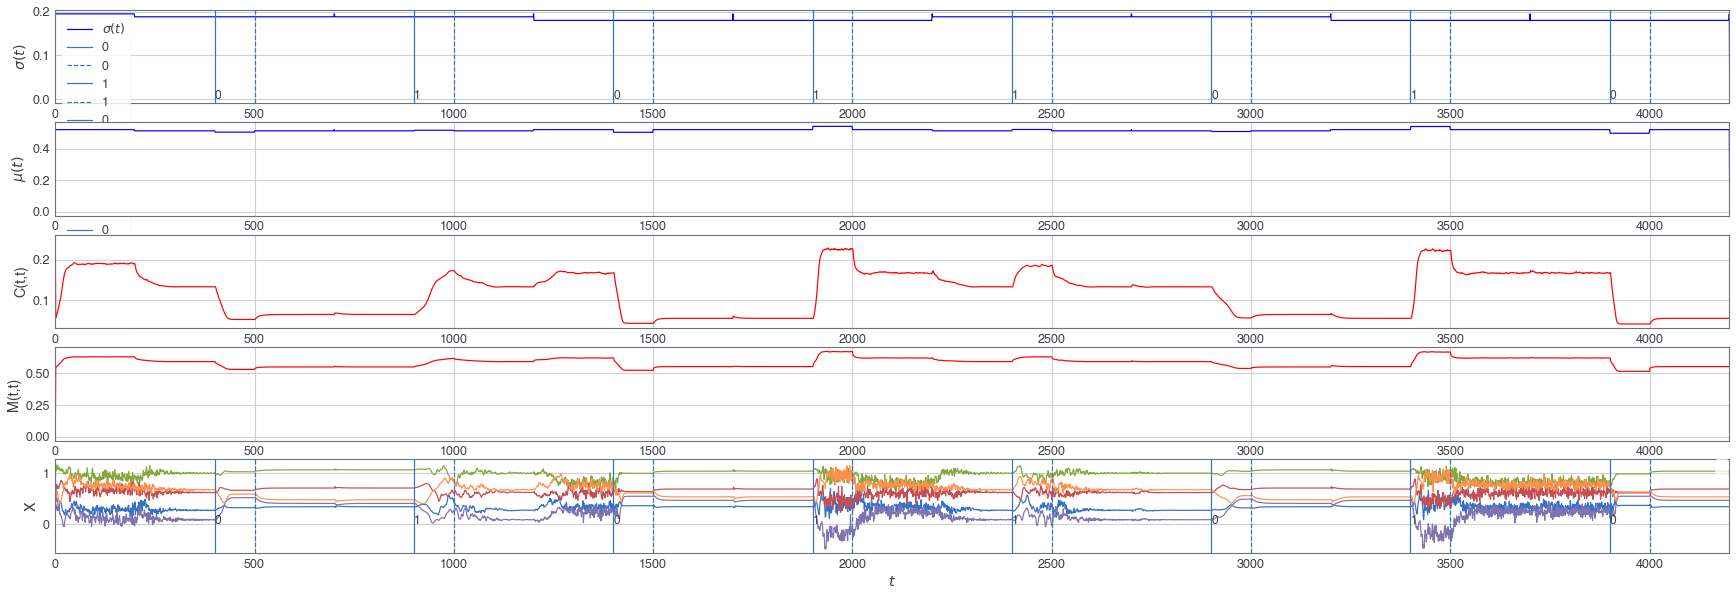

In [9]:
# load J matrix and quenched noise from good doubleFP run
file_data=os.path.join('DATA',"sim_ExploreBistablePhasesDoubleFP.pickle")
with open(file_data, 'rb') as handle:
    output = pickle.load(handle)
J=output["J"]
quench_noise1=output["quench_noise1"]

ntrials=2
#
stim_interval=200 # interval between 2 cons stimulations
stim_dur=100 # duration of a stimulation
stim_offset=200 # offset of first stim from beginning of sim or change of task rule

# phases
label_phases=['doubleFP','FPchaos']; 
mu_phases=[0.5125,0.52]; # double FP, FP/chaos
sigma_phases=[0.1883,0.18]; # double FP, FP/chaos

# construct time course for task rules
rule_set=[0,0,1,1,0,0,1,1] # choose rules for each trial
ntrials=len(rule_set)
mu_set=[mu_phases[i] for i in rule_set]; sigma_set=[sigma_phases[i] for i in rule_set]
rule_labels=[label_phases[i] for i in rule_set]
time_onset=[(stim_offset+i*(stim_offset+stim_interval+stim_dur)) for i in range(ntrials)]
time_offset=time_onset.copy()
time_offset.pop(0); time_offset.append(time_offset[-1]+(stim_offset+stim_interval+stim_dur))
time_offset=[x for x in time_offset]
step_n=time_offset[-1]+1 # end of simulation

# construct stimuli
# stimuli for the doubleFP
stim_class_doubleFP=['FP1','FP2']
mu_FP1=0.507; #sigma_FP=0.17; 
mu_FP2=0.517; #sigma_Chaos=0.2
mu_stim_doubleFP=[mu_FP1,mu_FP2] #; sigma_stim=[sigma_FP,sigma_Chaos]
# stimuli for the FP/mu_Chaos
stim_class_FPchaos=['FP','Chaos']
mu_FP=0.5; #sigma_FP=0.17; 
mu_Chaos=0.54; #sigma_Chaos=0.2
mu_stim_FPchaos=[mu_FP,mu_Chaos] #; sigma_stim=[sigma_FP,sigma_Chaos]
mu_stim=[mu_stim_doubleFP,mu_stim_FPchaos]
stim_class=[stim_class_doubleFP,stim_class_FPchaos]

stim_times=[x+stim_offset for x in time_onset]
stim=np.zeros(ntrials)
stim_labels=[0,1,0,1,1,0,1,0] # stim class within each task rule 
for i in range(ntrials):
    stim[i]=mu_stim[rule_set[i]][stim_labels[i]]

task_rule={'mu':mu_set,'sigma':sigma_set,'time_onset':time_onset,'time_offset':time_offset}
initial_var=0.5 # variance of initial conditions
stim_data={"stim":stim,"stim_times":stim_times,'stim_labels':stim_labels,"stim_interval":stim_interval,"stim_dur":stim_dur,"stim_offset":stim_offset,'jitter':True}
parameters1={"neuron_n":neuron_n,"replica_n":replica_n,"step_n":step_n,"time_slice":time_slice,"act_type":act_type} 
parameters5={"g_scale":g_scale,"J_bias":J_bias,"mu":mu,"theta":theta,"c":c,"sigma_ind":sigma_ind,"initial_var":initial_var,"stim_data":stim_data,"J":J,'quench_noise1':quench_noise1,"task_rule":task_rule} 

start = time.time()
# sigma = torch.zeros(step_n,device = device)
RRNNN = rn.RecurrentRandomNeuralNetworkNbody(**parameters1)

output = RRNNN.evolve_rrnn_switch(**parameters5)
pdffigname = "switch_g"+str(g_scale)+"_Jbias"+str(J_bias)+"_c"+str(c)+"_theta"+str(theta)+"_neuron_n"+str(neuron_n)+".pdf"
rn.plot_time_course_stim(step_n,output,stim_data,time_slice,pdffigname)
output["J"]=[]
output["quench_noise1"]=[]
output["stim_data"]=stim_data
output["parameters1"]=parameters1
output["parameters5"]=parameters5

file_data=os.path.join('DATA',"sim_long_session.pickle")
with open(file_data, 'wb') as fp:
    pickle.dump(output, fp, protocol=pickle.HIGHEST_PROTOCOL)# with open(file_data, 'r') as f:


Nice plot including decoder readout for task rule and stimulus class

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


hozon


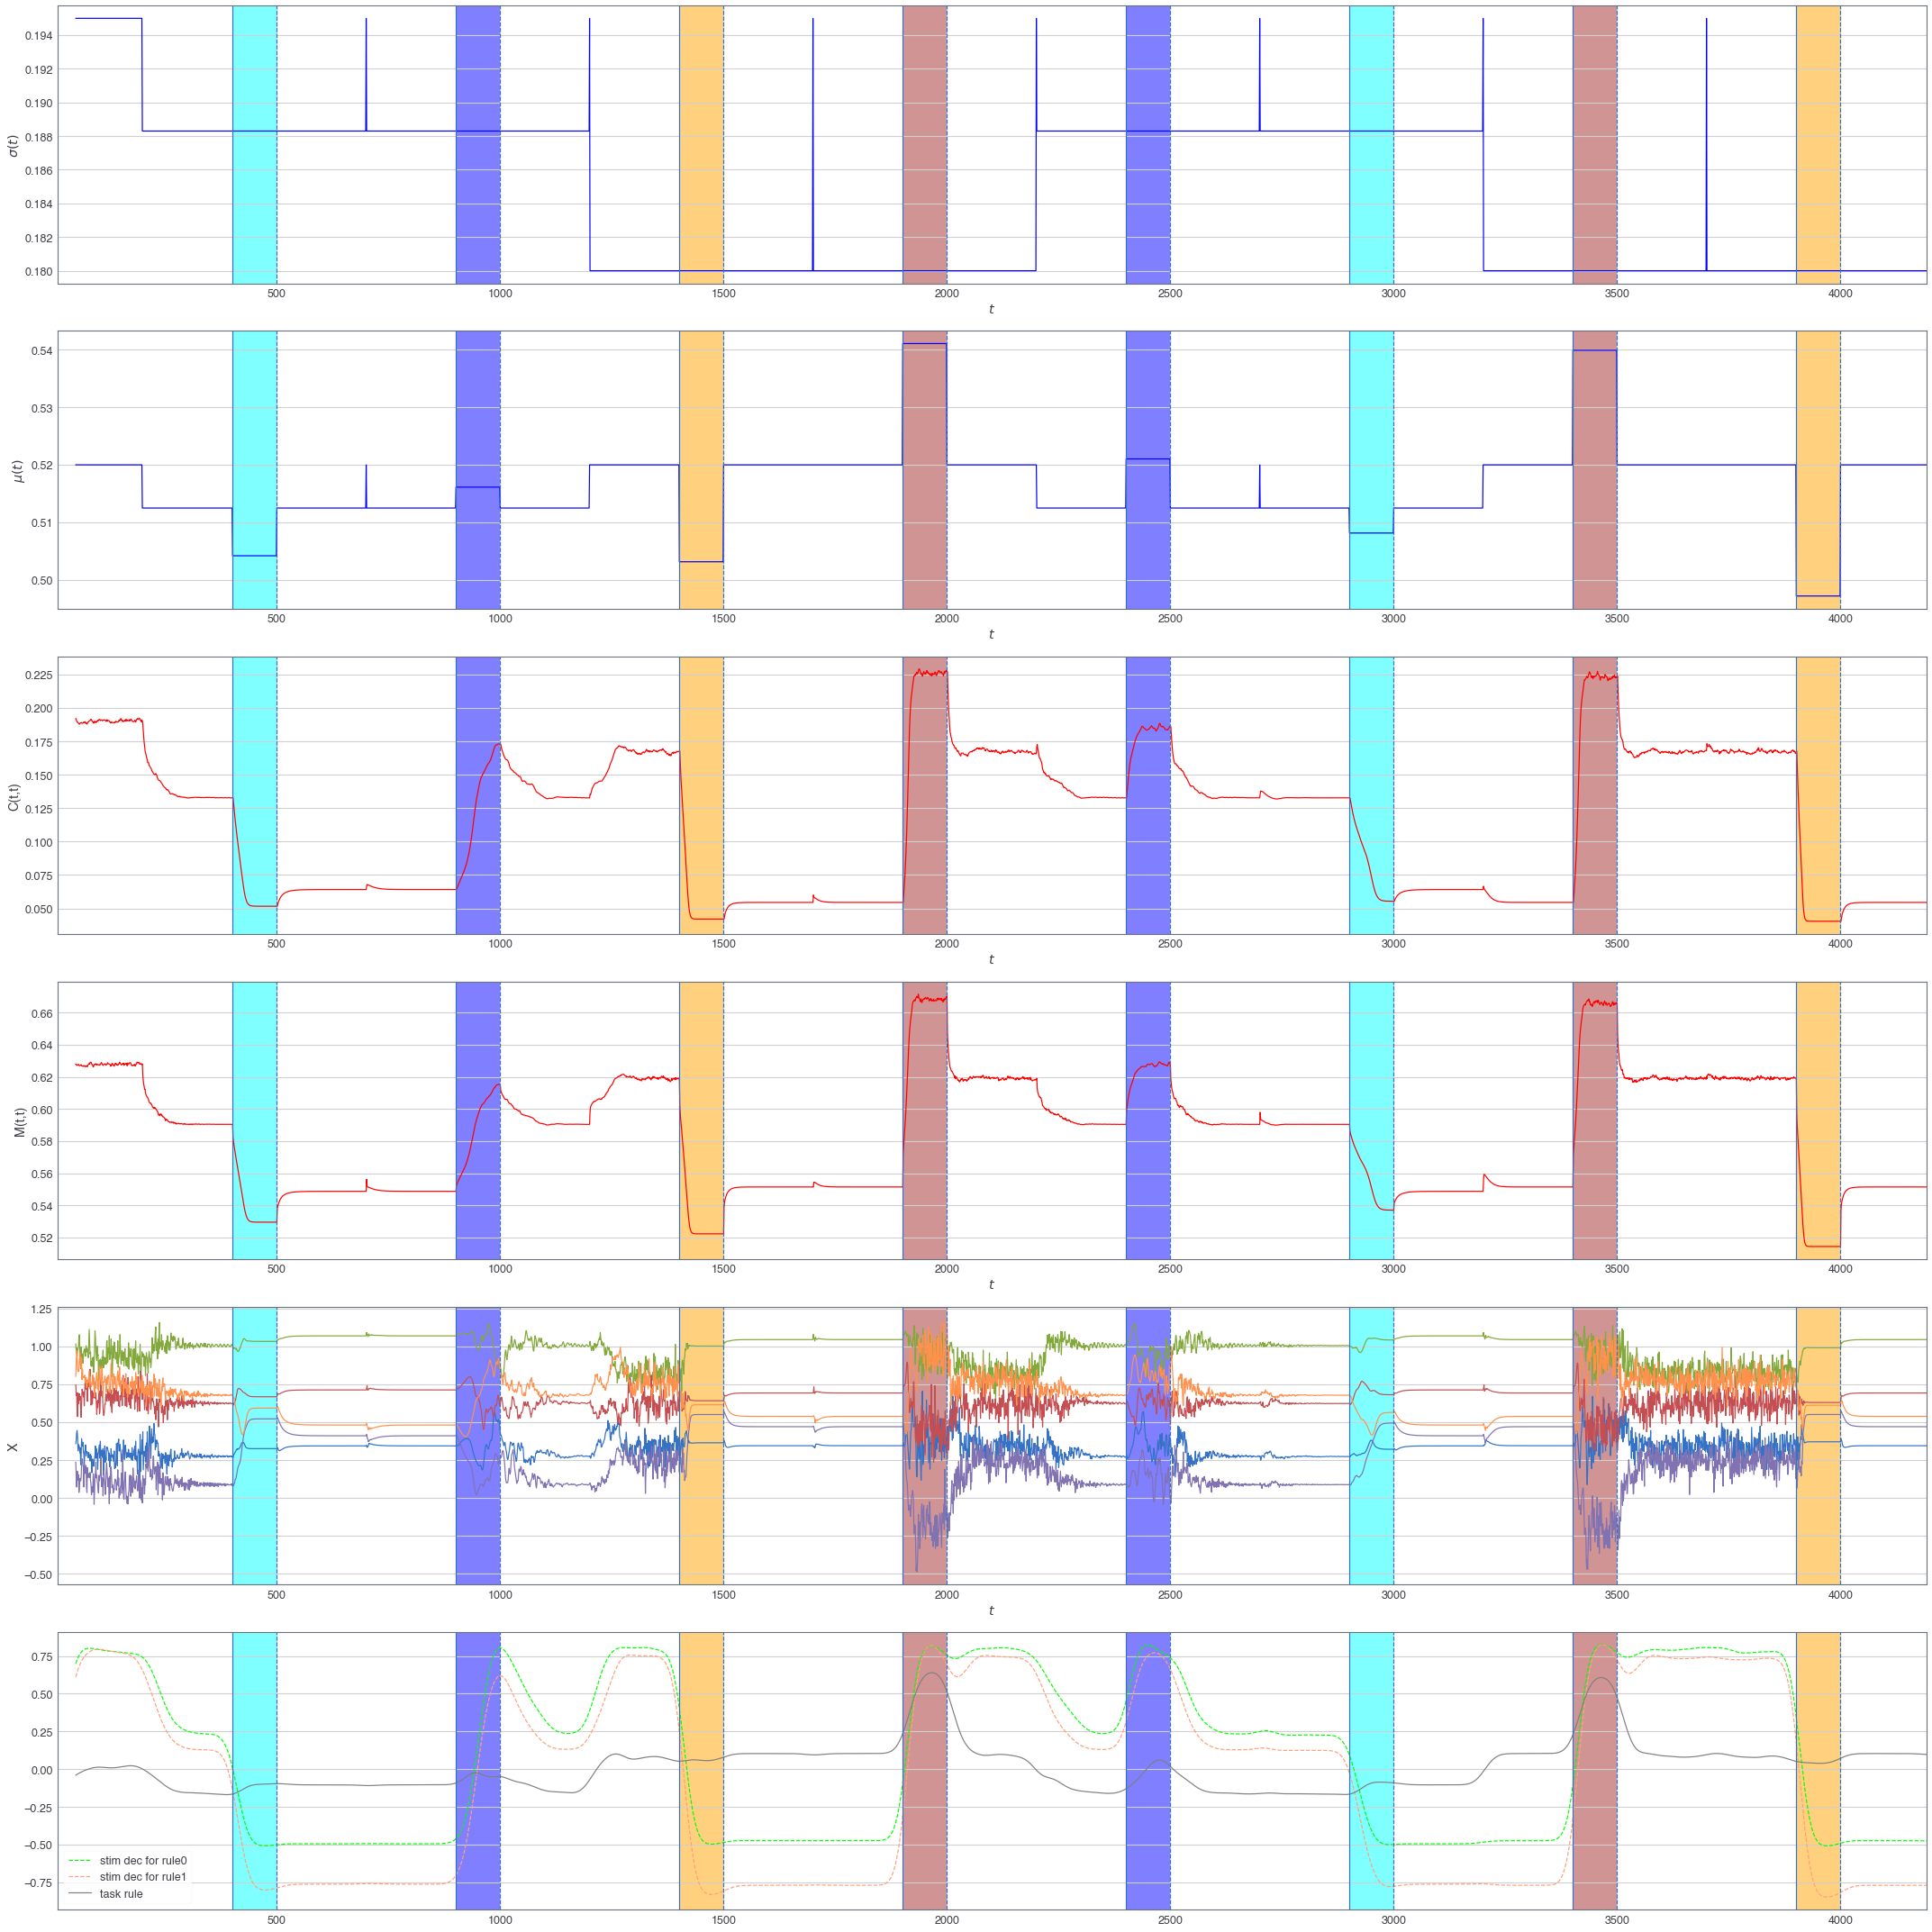

In [25]:
# file_data=os.path.join('DATA',"1sim_doubleFP_decoder.pickle")
# with open(file_data, 'rb') as fp:
#     readouts = pickle.load(fp)
from scipy.ndimage import gaussian_filter1d

n_rules=2

file_data=os.path.join('DATA',"sim_long_session.pickle")
with open(file_data, 'rb') as fp:
    output=pickle.load(fp)# with open(file_data, 'r') as f:
file_data=os.path.join('DATA',"1sim_doubleFP_decoder.pickle")
with open(file_data, 'rb') as fp:
    readouts=pickle.load(fp)# with open(file_data, 'r') as f:

color_stim=[['cyan','blue'],['orange','brown']]
color_rule=['lime','lightsalmon']

sigma = output['sigma'].cpu().detach().numpy()
mu_plot = output['mu'].cpu().detach().numpy()
Mean = output['M'].cpu().detach().numpy()
X= output['X'].cpu().detach().numpy()
Var = output['C'].cpu().detach().numpy()
step_n=X.shape[1]-1
# stim_data={"stim":stim,"stim_times":stim_times,'stim_labels':stim_labels,"stim_interval":stim_interval,"stim_dur":stim_dur,"stim_offset":stim_offset}
stim_data=output["stim_data"]
stim_times=stim_data['stim_times']
stim_labels=stim_data['stim_labels']
stim_dur=stim_data['stim_dur']

t=np.zeros(step_n+1)
ind0=np.arange(50,step_n)
# t[0]=0; 
for i in range(step_n): t[i+1]=t[i]+time_slice


jtplot.style(theme='grade3')
cm=plt.get_cmap('Blues') ; cm_interval=[ i /step_n for i in range(1, step_n+1) ] ; cm=cm(cm_interval)
nplots=6
fig, ax = plt.subplots(nplots,1, figsize=(30,30))
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=18)
## Trajectory as a function of time
ax[0].plot(t[ind0],sigma[ind0], color="blue", label = "$\sigma(t)$")
ax[1].plot(t[ind0],mu_plot[ind0], color="blue", label = "$\mu$")
ax[2].plot(t[ind0],Var[ind0], color="red", label = "$C(t,t)$")
ax[3].plot(t[ind0],Mean[ind0], color="red", label = "$M(t,t)$")
ax[0].set_xlabel("$t$"); ax[0].set_ylabel("$\sigma(t)$")
ax[1].set_xlabel("$t$"); ax[1].set_ylabel("$\mu(t)$")
ax[2].set_xlabel("$t$") ; ax[2].set_ylabel("C(t,t)")
ax[3].set_xlabel("$t$"); ax[3].set_ylabel("M(t,t)")
for i in range(5):
    ax[4].plot(t[ind0],X[i,ind0], label = "X"+str(i))
    ax[4].set_xlabel("$t$") ; ax[4].set_ylabel("X")
# stim readout
for irule in range(n_rules):
    Xlda=readouts['stim'][irule]["LDA_stim"].transform(X.T) # readout for stim class
    y=gaussian_filter1d(Xlda.T/np.max(Xlda),20); y=y.T
    ax[5].plot(t[ind0],y[ind0], color=color_rule[irule],linestyle='--', label = "stim dec for rule" + str(irule))
# rule readout
Xlda=readouts["LDA_rule"].transform(X.T) # readout for stim class
y=gaussian_filter1d(Xlda.T/np.max(Xlda),20); y=y.T
ax[5].plot(t[ind0],y[ind0], color='gray', label = "task rule")
ax[5].legend()
for i in range(nplots): ax[i].set_xlim([t[10],t[-10]])

    
for iplot in range(nplots):
    for i in range(len(stim_times)):
        stext=stim_class[rule_set[i]][stim_labels[i]]
        # ax[iplot].text(stim_times[i],stext, fontsize=12)    
        ax[iplot].axvline(stim_times[i],0,label=(stim_class[rule_set[i]][stim_labels[i]])) 
        ax[iplot].axvline(stim_times[i]+stim_dur,linestyle='--',label=(stim_class[rule_set[i]][stim_labels[i]])) 
        ax[iplot].axvspan(stim_times[i], stim_times[i]+stim_dur, facecolor=color_stim[rule_set[i]][stim_labels[i]], alpha=0.5)


plt.tight_layout()

hozon= True 

if hozon == True:
    pdffigname = "switch_g"+str(g_scale)+"_Jbias"+str(J_bias)+"_c"+str(c)+"_theta"+str(theta)+"_neuron_n"+str(neuron_n)+".pdf"
    pngfigname = "switch_g"+str(g_scale)+"_Jbias"+str(J_bias)+"_c"+str(c)+"_theta"+str(theta)+"_neuron_n"+str(neuron_n)+".png"
    fig.savefig(pdffigname)
    fig.savefig(pngfigname)
    print("hozon")
    jtplot.style(theme='monokai') 
else:
    print("Any figure hasn't been saved!")
    jtplot.style(theme='monokai') 

np.savetxt("temporal_seq_forget.csv", X[0:11,1000:5000].T, delimiter=",")

### Save and Plot 

### Decoding memory

In [9]:
anan=np.zeros((ntrial,len(X_out[0])))
for i in range(ntrial):
        for ineu in range(len(X_out[0])):
                anan[i,ineu]=np.any(np.isnan(X_out[i][ineu]))
atrial=np.any(anan,axis=0)
print('neurons with some nan entries in some trials')
print(np.where(atrial))
X_out1=X_out[:,~atrial,:]


neurons with some nan entries in some trials
(array([  3,  22,  30,  40,  45,  59,  62,  65,  71,  75, 101, 107, 108,
       111, 117, 125, 126, 127, 130, 137, 142, 153, 163, 165, 198, 223,
       226, 230, 243, 246, 281, 283, 307, 309, 311, 314, 325, 351, 355,
       357, 361, 362, 387, 414, 415, 416, 420, 423, 424, 438, 453, 476,
       479, 484, 490, 491, 498]),)


In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import StratifiedKFold
import multiprocessing as mp
NumThread=(mp.cpu_count()-1)*2 # sets number of workers based on cpus on current machine
nProcesses=NumThread

parallel=True
ndecstim=50
dec_times=np.zeros(ndecstim*len(stim_times))
for i in range(len(stim_times)):
    for idec in range(ndecstim):
        dec_times[ndecstim*i+idec]=stim_times[i]+2*idec
dec_accuracy=np.zeros((nstim,len(dec_times))) # this is the decoding accuracy for each stimulus pairs (nseq) at each time point
# n_features=X_out.shape[1]
nKfold=5
# DECODING
#Create cross-validation object
k_fold = StratifiedKFold(n_splits=nKfold)
classifier='LDA'
#Initialize Classifier
if classifier == 'LDA':
    clf = LinearDiscriminantAnalysis()
elif classifier == 'SVM':
    clf = svm.LinearSVC(penalty='l1',dual=False, max_iter=1E6)
elif classifier == 'QDA':
    clf = QuadraticDiscriminantAnalysis()
        
for i in range(nstim):
    ylabel=y[:,i]
    
    for idec in range(len(dec_times)):
        ind_t_dec=np.argmin(np.abs(timebins-dec_times[idec]))
        X_t=np.array(np.mean(X_out1[:,:n_stim_neuron*2*nstim,ind_t_dec:ind_t_dec+5],axis=2))
        inans=np.argwhere(np.isnan(X_t))
        # evaluate model
        scores = cross_val_score(clf, X_t, ylabel, scoring='accuracy', cv=k_fold, n_jobs=-1)
        # results = cross_validate(clf, X_t, ylabel, scoring='accuracy', cv=k_fold, n_jobs=-1)
        dec_accuracy[i,idec]=scores.mean()



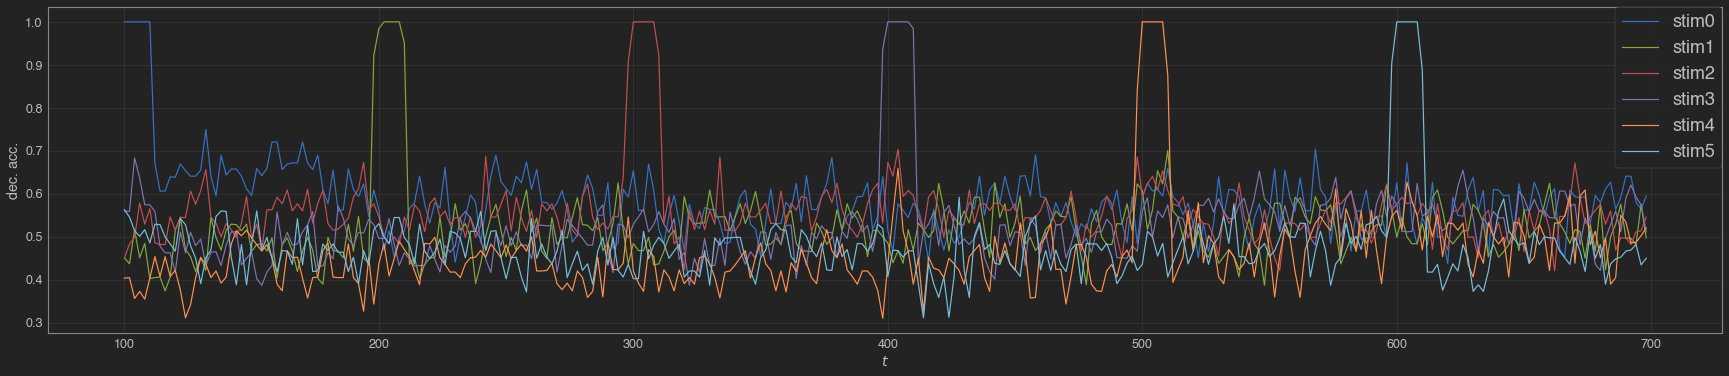

In [29]:
# plot decoding results
fig = plt.figure(figsize=(30,6))
for i in range(nstim):
          plt.plot(dec_times,dec_accuracy[i,:], label = "stim"+str(i))
          plt.xlabel("$t$")
          plt.ylabel("dec. acc.")
          plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=18)
pdffigname = "decoding"+str(g_scale)+"_Jbias"+str(J_bias)+"_c"+str(c)+"_theta"+str(theta)+".pdf"
pdffigname = "decoding"+str(g_scale)+"_Jbias"+str(J_bias)+"_c"+str(c)+"_theta"+str(theta)+".png"
fig.savefig(pdffigname)
fig.savefig(pngfigname)
jtplot.style(theme='monokai') #これ以降でこのノートを見やすい色で使用するために最後にスタイルを戻しておく

